## 简介
通过Scikit-Learn实现多类别文本分类

原文：https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

译文：https://www.jiqizhixin.com/articles/2018-03-05-3

数据集：https://www.kaggle.com/sebastienverpile/consumercomplaintsdata


该问题是监督式文本分类问题，数据集为产品品投诉文本，一共有18种产品，我们想要解决的就是训练一个分类器，可以将文本自动分类到原本属于的分类。

## 数据分析

In [85]:
import pandas as pd
df=pd.read_csv('data/Consumer_Complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


输入是：Consumer_complaint_narrative  消费者投诉叙述

输出是：Product	 具体产品类别

我们将删除「Consumer_complaint_narrative」栏中的缺失值，并添加一列来将Product编码为整数，创建了几个字典供将来使用。

清理完成后的前五行数据：

In [86]:
from io import StringIO
col=['Product','Consumer complaint narrative']
df=df[col]
df=df[pd.notnull(df['Consumer complaint narrative'])]
df.columns=['product','complaint_text']
df=df[:10000]
df['category_id']=df['product'].factorize()[0]
category_id_df = df[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id=dict(category_id_df.values)
id_to_category=dict(category_id_df[['category_id','product']].values)

In [87]:
df.head()

,product,complaint_text,category_id
1,Credit reporting,I have outdated information on my credit repor...,0
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,1
7,Credit reporting,An account on my credit report has a mistaken ...,0
12,Debt collection,This company refuses to provide me verificatio...,2
16,Debt collection,This complaint is in regards to Square Two Fin...,2


## 类别不均衡

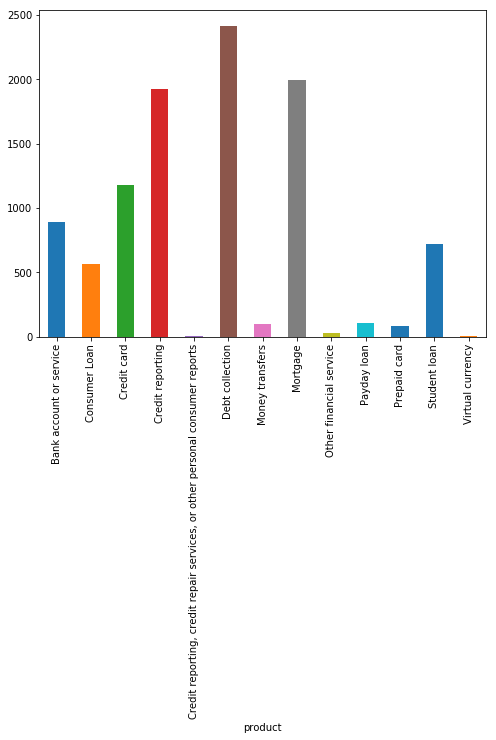

In [88]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,6))
df.groupby('product').complaint_text.count().plot(kind='bar',ylim=0)
plt.show()

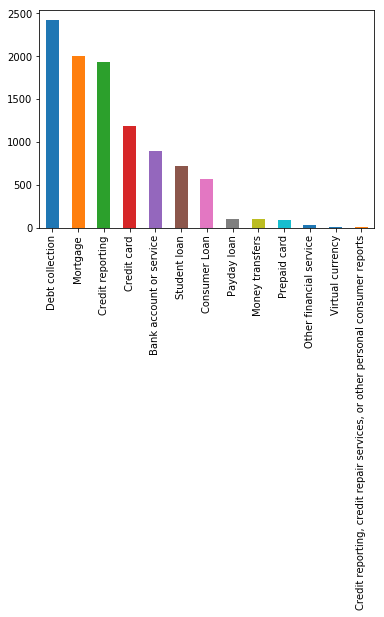

In [89]:
df['product'].value_counts().plot(kind='bar')
plt.show()

我们可以看到，类别数量差别很大。一般情况下，常规算法一般预测的时候会更倾向于数量多的类别，最糟糕的情况是数量少的类别会直接被忽略掉。对于某些情况，如欺诈检测或癌症预测，我们则需要仔细配置我们的模型或人为地平衡数据集，比如欠采样或过采样每个类别。

但是，在学习不平衡数据的情况下，我们最感兴趣的是数量多的类别。我们想有一个分类器，能够对多数类提供较高的预测精度，同时对少数类保持合理的准确度。

## 文本表示
分类器和学习算法不能直接处理原始形式的文本文档，需要将文本数值化转化为向量才可以处理。

从文本中提取特征的一种常见方法是使用词袋模型

具体来说，对于我们数据集中的每一个关于产品的投诉文本，我们将计算一种被称为词频、反向文档频率的值，其缩写为 tf-idf。我们将使用 sklearn.feature_extraction.text.TfidfVectorizer 为每个消费者投诉叙述文本计算一个 tf-idf 向量。

TfidfVectorizer 常用参数：
- sublinear_df 设为 True 从而使用频率的对数形式。
- min_df 是单词必须存在的最小文档数量。
- norm 设为 l2，以确保我们所有特征向量的欧几里德范数为 1。
- ngram_range 设为 (1, 2)，表示我们想要考虑 unigrams 和 bigrams。
- stop_words 设为 "english" 来删除所有常用代词 ("a", "the", ...) 以减少噪音特征的数量。

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(sublinear_tf=True,min_df=5,norm='l2',encoding='latin-1',ngram_range=(1,2),stop_words='english')
features=tfidf.fit_transform(df.complaint_text).toarray()
labels=df.category_id
features.shape

(10000, 26704)

现在，10000个消费者投诉描述中的每一个由 26704 个特征表达，代表不同的 unigrams 和 bigrams 的 tf-idf 分数。

我们可以使用 sklearn.feature_selection.chi2 来查找与每个产品最相关的词语：

In [91]:
from sklearn.feature_selection import chi2
import numpy as np
N=2
for product,category_id in sorted(category_to_id.items()):
    features_chi2=chi2(features,labels==category_id)
    indices=np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(product))
    print("(1) Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("(2) Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
(1) Most correlated unigrams:
. deposit
. overdraft
(2) Most correlated bigrams:
. overdraft fees
. checking account
# 'Consumer Loan':
(1) Most correlated unigrams:
. car
. vehicle
(2) Most correlated bigrams:
. santander consumer
. car loan
# 'Credit card':
(1) Most correlated unigrams:
. capital
. card
(2) Most correlated bigrams:
. annual fee
. credit card
# 'Credit reporting':
(1) Most correlated unigrams:
. experian
. equifax
(2) Most correlated bigrams:
. trans union
. credit report
# 'Credit reporting, credit repair services, or other personal consumer reports':
(1) Most correlated unigrams:
. birth
. iam
(2) Most correlated bigrams:
. birth year
. correct date
# 'Debt collection':
(1) Most correlated unigrams:
. collection
. debt
(2) Most correlated bigrams:
. collect debt
. collection agency
# 'Money transfers':
(1) Most correlated unigrams:
. paypal
. western
(2) Most correlated bigrams:
. money transfer
. western union
# 'Mortgage':
(1) Most cor

## 多类别分类器
- 为了训练监督式分类器，我们首先将「消费者投诉叙述」转化为数字向量。我们研究了向量表示，例如 TF-IDF 加权向量。

- 有了这个向量表达的文本后，我们可以训练监督式分类器来训练看不到的「消费者投诉叙述」并预测它们的「产品」。

在完成上述数据转换之后，现在我们得到了所有的特征，下面我将设计分类器

- 朴素贝叶斯分类器

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [93]:
X_train,X_test,y_train,y_test=train_test_split(df['complaint_text'],df['product'],random_state=42)
count_vect=CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

分类器拟合训练好之后，我们做一些预测

In [94]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [95]:
df[df['complaint_text'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,product,complaint_text,category_id
12,Debt collection,This company refuses to provide me verificatio...,2


In [96]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting']


In [97]:
df[df['complaint_text'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,product,complaint_text,category_id
61,Credit reporting,I am disputing the inaccurate information the ...,0


我们可以看到效果还可以

## 模型选择
我们现在准备尝试不同的机器学习模型，评估它们的准确性并找出潜在问题的根源。

我们将对以下四种模型进行基准测试：

- Logistic 回归
- （多项式）朴素贝叶斯
- 线性支持向量机
- 随机森林

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The mi

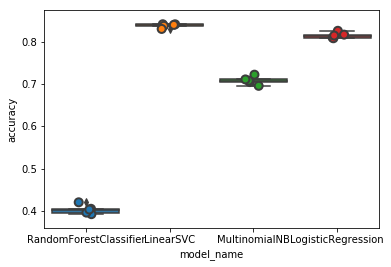

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
 RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
 LinearSVC(),
 MultinomialNB(),
 LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [99]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.837699
LogisticRegression        0.814695
MultinomialNB             0.707997
RandomForestClassifier    0.403287
Name: accuracy, dtype: float64

## 模型评估

继续使用我们的最佳模型（LinearSVC），我们将查看混淆矩阵，并展示预测标签和实际标签之间的差异。

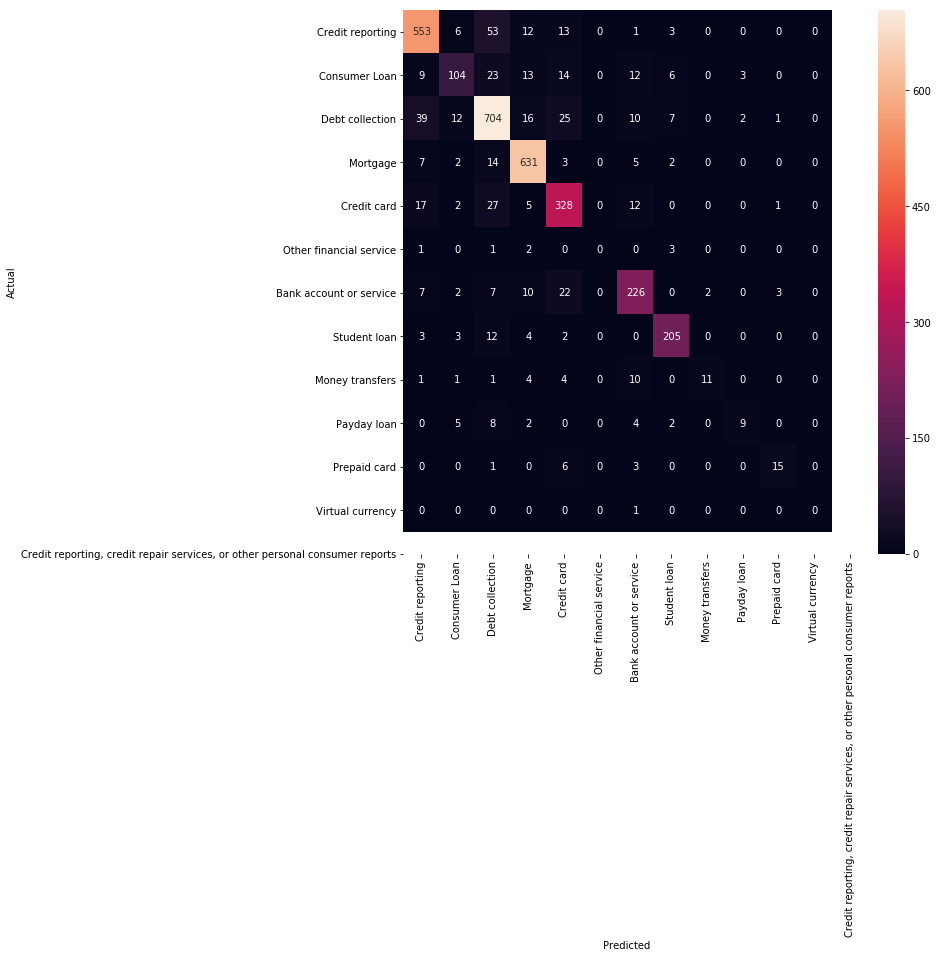

In [100]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df['product'].values, yticklabels=category_id_df['product'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

正如我们所希望的，绝大多数预测都在对角线（预测标签=实际标签）。然而，仍然存在大量错误分类，看看这些是由什么造成：

In [102]:
from IPython.display import display
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['product', 'complaint_text']])
            print('')

'Debt collection' predicted as 'Credit reporting' : 39 examples.


,product,complaint_text
44328,Debt collection,There is a collation on my XXXX and XXXX repor...
12119,Debt collection,they are overly charging me for for cleaning. ...
18054,Debt collection,XXXX Hospital sent my account to Financial Rec...
35573,Debt collection,Carter-Young INC said I signed a lease in XXXX...
30902,Debt collection,"XXXX XXXX XXXX XXXX XXXX XXXX, XXXX XXXX XXXX,..."
41982,Debt collection,There is an account that is my wife 's only an...
33755,Debt collection,on XXXX XXXX i was checking my credit report w...
22988,Debt collection,Inaccurate reporting of a tradeline to all XXX...
45213,Debt collection,Requested Midwest Service Bureau to not call m...
35103,Debt collection,Never had services with XXXX.



'Credit card' predicted as 'Credit reporting' : 17 examples.


,product,complaint_text
21876,Credit card,To whom this may concern I have been applying ...
23561,Credit card,When signing in with customer service represen...
23923,Credit card,The Chase account has been reporting on my per...
42768,Credit card,There is a Capital One account on my credit re...
37930,Credit card,I recently discovered an unauthorized hard inq...
7124,Credit card,To whom it may concern : XXXX has charged me f...
43003,Credit card,"Chase added old, outdated information from my ..."
22396,Credit card,"To Whom it May Concern, I would like to file a..."
34313,Credit card,This agency is reporting an account on my redi...
23475,Credit card,Just not my account and showing under my XXXX ...


IndexError: index 12 is out of bounds for axis 0 with size 12

In [103]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Virtual currency':
  . Top unigrams:
       . bank
       . branch
  . Top bigrams:
       . debit card
       . xxxx police
# 'Virtual currency':
  . Top unigrams:
       . car
       . vehicle
  . Top bigrams:
       . got loan
       . gm financial
# 'Virtual currency':
  . Top unigrams:
       . card
       . discover
  . Top bigrams:
       . credit card
       . minimum payment
# 'Virtual currency':
  . Top unigrams:
       . equifax
       . transunion
  . Top bigrams:
       . xxxx account
       . trans union
# 'Virtual currency':
  . Top unigrams:
       . iam
       . birth
  . Top bigrams:
       . correct date
       . birth year
# 'Virtual currency':
  . Top unigrams:
       . debt
       . collection
  . Top bigrams:
       . trying collect
       . account credit
# 'Virtual currency':
  . Top unigrams:
       . paypal
       . transfer
  . Top bigrams:
       . western union
       . money transfer
# 'Virtual currency':
  . Top unigrams:
       . mortgage
       . es